# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.


> # Contents <a id='back'></a>
> * [Introduction](#intro)
    * [Stage 1. Initialization](#Initialization)
    * [Stage 2. Load Data](#Load-Data)
    * [Stage 3. EDA](#EDA)
    * [Stage 4. Evaluation Procedure](#Evaluation-Procedure)
    * [Stage 5. Normalization](#Normalization)
    * [Stage 6. Train / Test Split](#Train-/-Test-Split)
    * [Stage 7. Working with models](#Working-with-models)
        * [7.1 Model 0 - Constant](#Model-0---Constant)
        * [7.2 Model 1 - NLTK, TF-IDF and LR](#Model-1---NLTK,-TF-IDF-and-LR)
        * [7.3 Model 3 - spaCy, TF-IDF and LR](#Model-3---spaCy,-TF-IDF-and-LR)
        * [7.4 Model 4 - spaCy, TF-IDF and LGBMClassifier](#Model-4---spaCy,-TF-IDF-and-LGBMClassifier)
        * [7.5 Model 9 - BERT](#Model-9---BERT)
    * [Stage 8. My Reviews](#My-Reviews)
        * [8.1 Model 1](#Model-1)        
        * [8.1 Model 3](#Model-3)     
        * [8.1 Model 4](#Model-4)     
        * [8.1 Model 9](#Model-9)     
    * [Findings](#end)

## Initialization

In [1]:
import math
import re
import numpy as np
import pandas as pd
from scipy.stats import randint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score
import spacy
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.head(4)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280


At a quick glance, the dataset has 47331 rows of reviews. There are 2 missing values in average_rate and votes out of the entire dataset. Since the number of missing values is insignificant, I will proceed to drop the 2 rows.

In [7]:
df_reviews.dropna(inplace=True)
df_reviews.reset_index(inplace=True)

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47329 entries, 0 to 47328
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            47329 non-null  int64  
 1   tconst           47329 non-null  object 
 2   title_type       47329 non-null  object 
 3   primary_title    47329 non-null  object 
 4   original_title   47329 non-null  object 
 5   start_year       47329 non-null  int64  
 6   end_year         47329 non-null  object 
 7   runtime_minutes  47329 non-null  object 
 8   is_adult         47329 non-null  int64  
 9   genres           47329 non-null  object 
 10  average_rating   47329 non-null  float64
 11  votes            47329 non-null  Int64  
 12  review           47329 non-null  object 
 13  rating           47329 non-null  int64  
 14  sp               47329 non-null  object 
 15  pos              47329 non-null  int64  
 16  ds_part          47329 non-null  object 
 17  idx         

In [8]:
df_reviews.duplicated().sum()

0

We have successfully removed duplicates and there are no duplicated values

In [9]:
df_reviews.value_counts('pos')

pos
0    23715
1    23614
dtype: int64

The positive and negative reviews are quite balanced. 

## EDA

Let's check the number of movies and reviews over years.

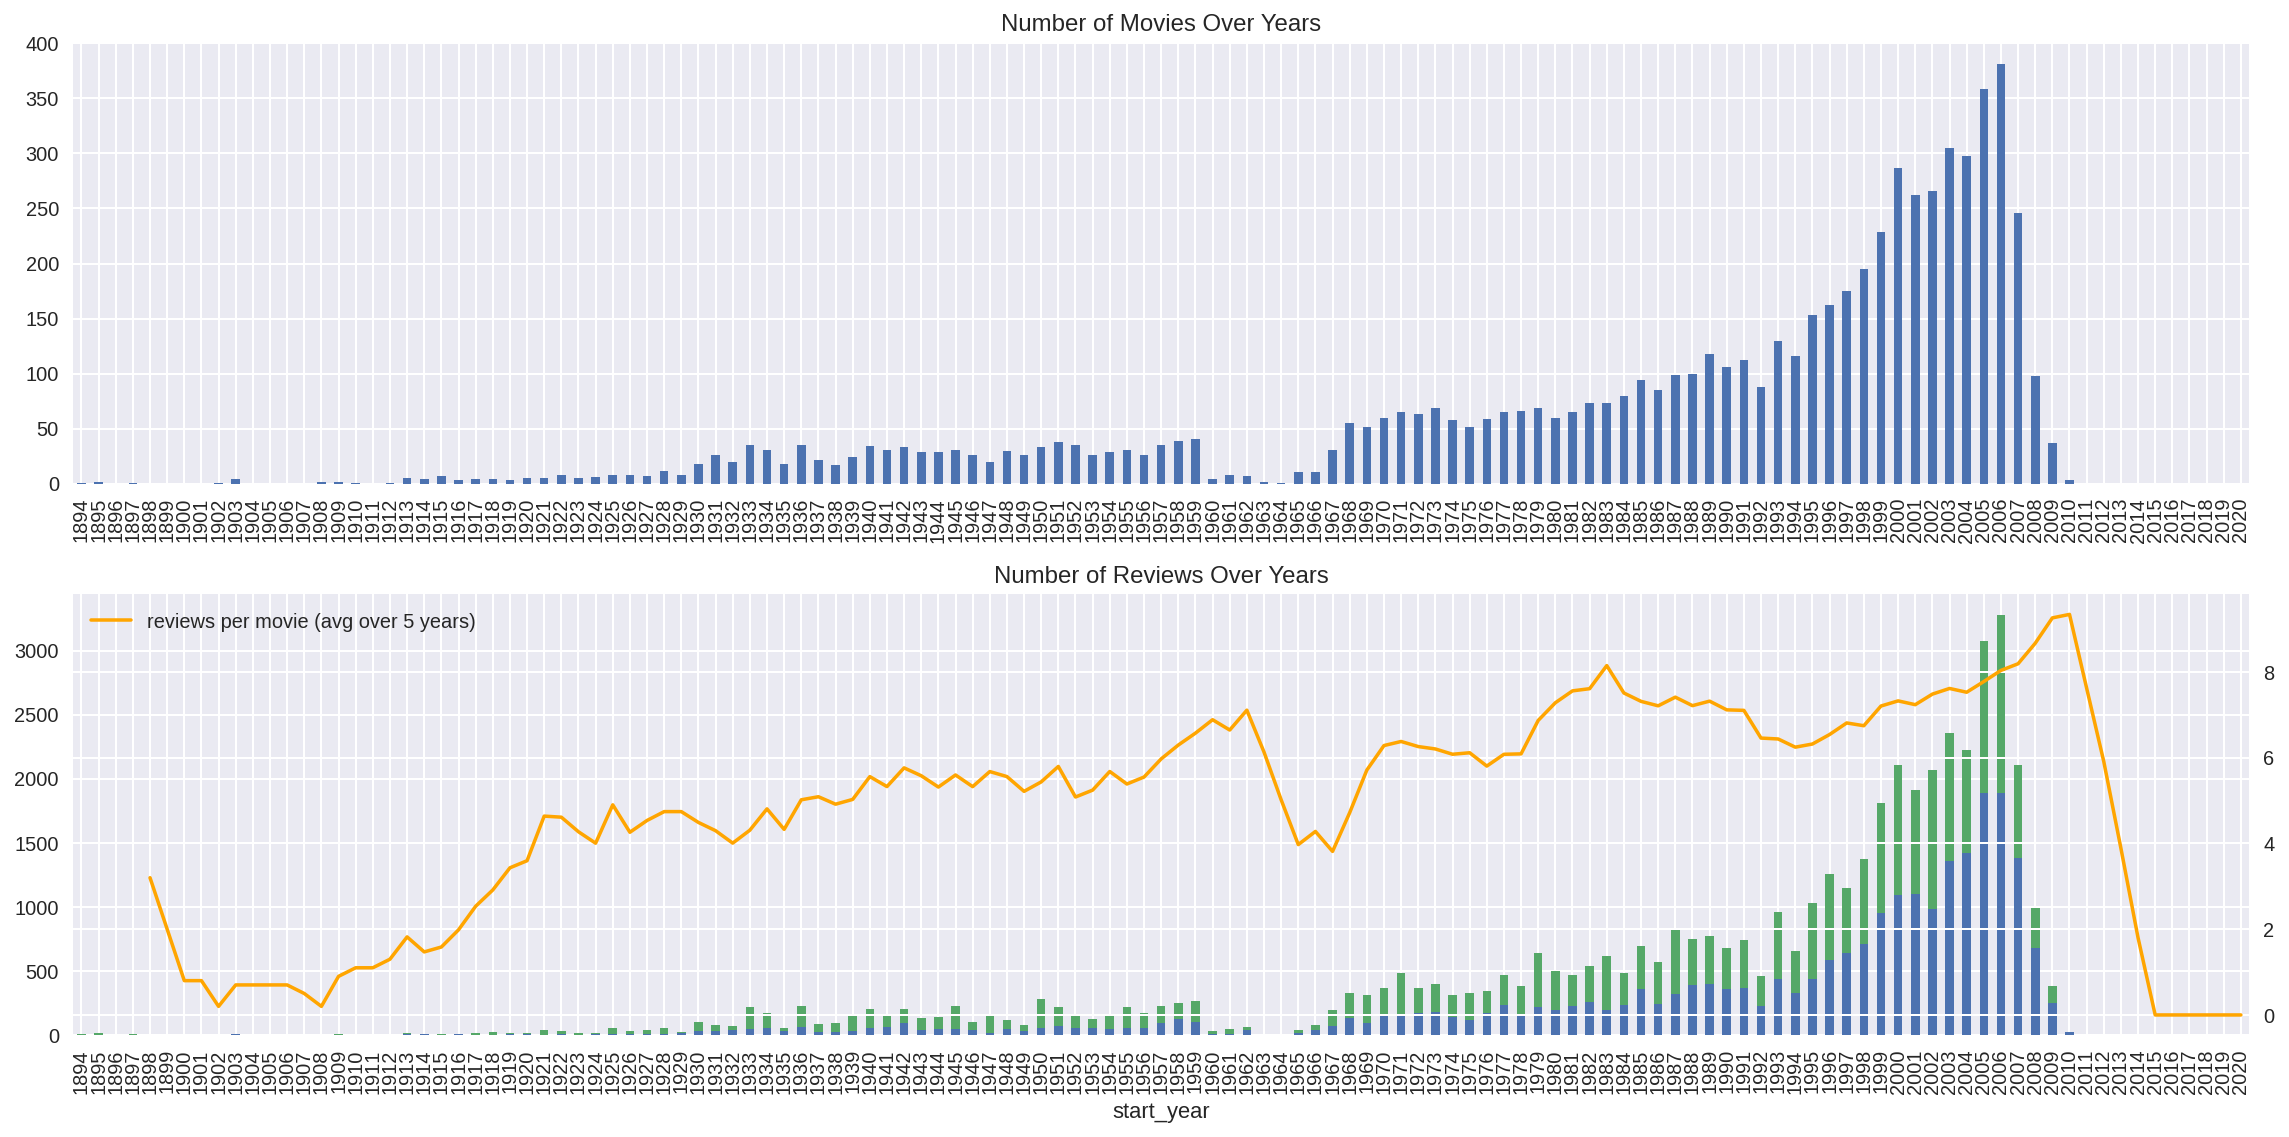

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

We can see that there is an increasing trend of movie reviews until 2007. Will need to further investigation as to why there is a sudden drop of number of reviews after 2007.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

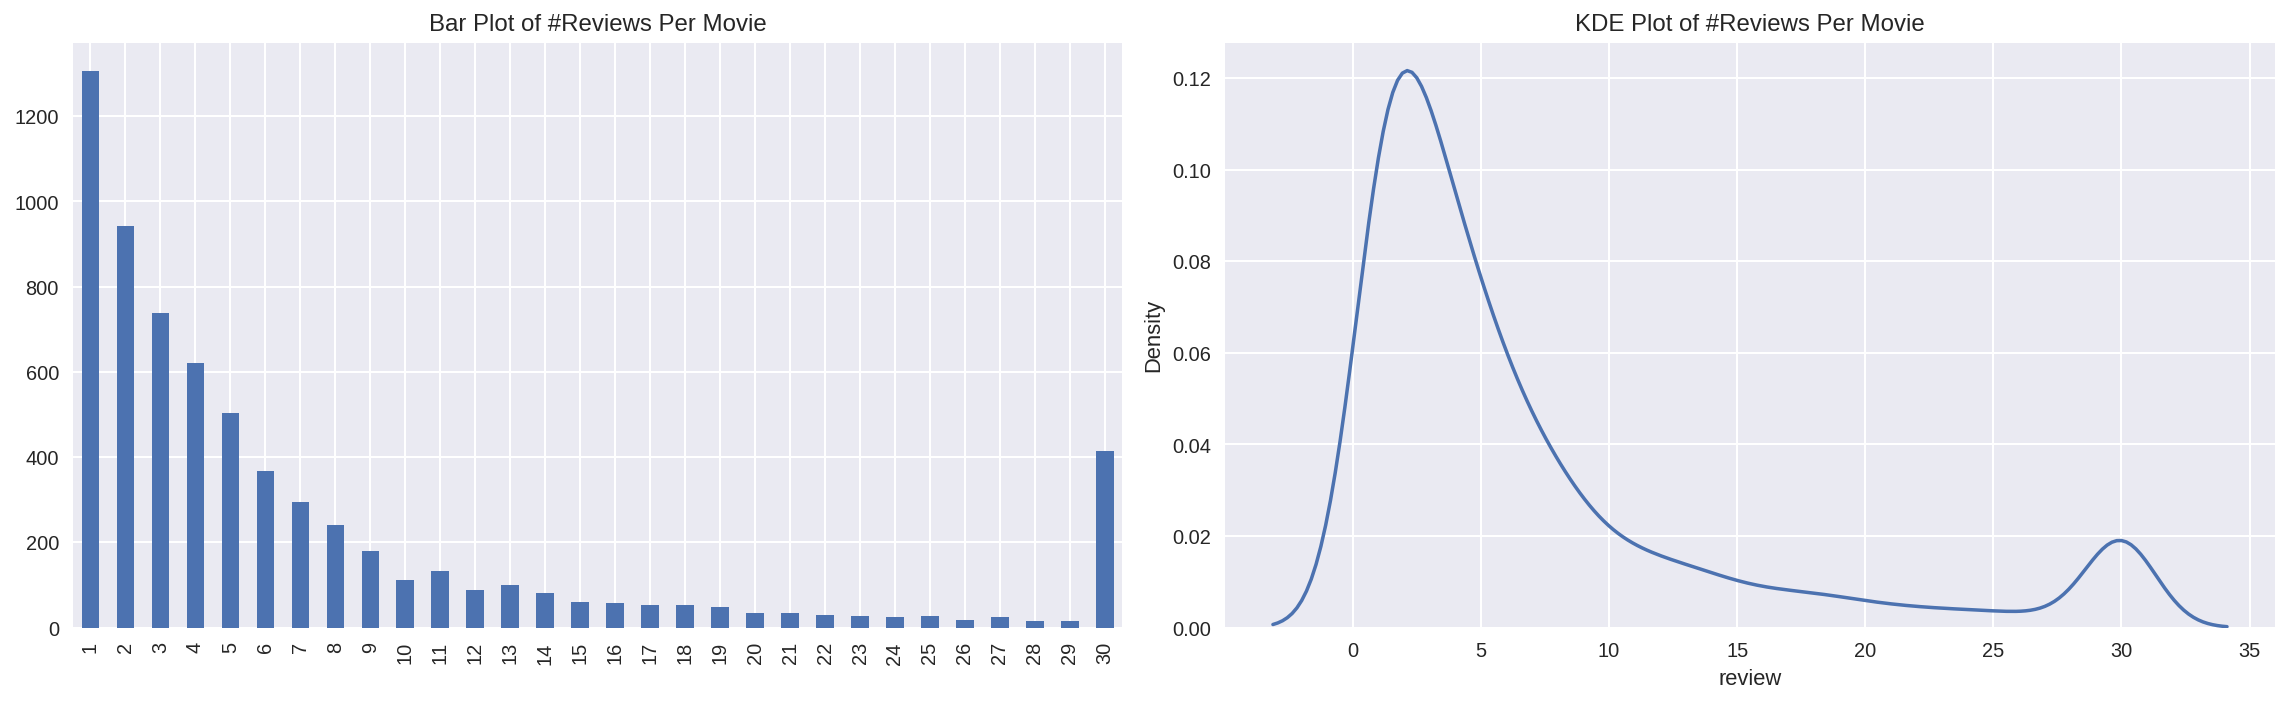

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

We can see that the number of review is positively skewed. Most movies has 1 review and the number of reviews slowly decreases. 

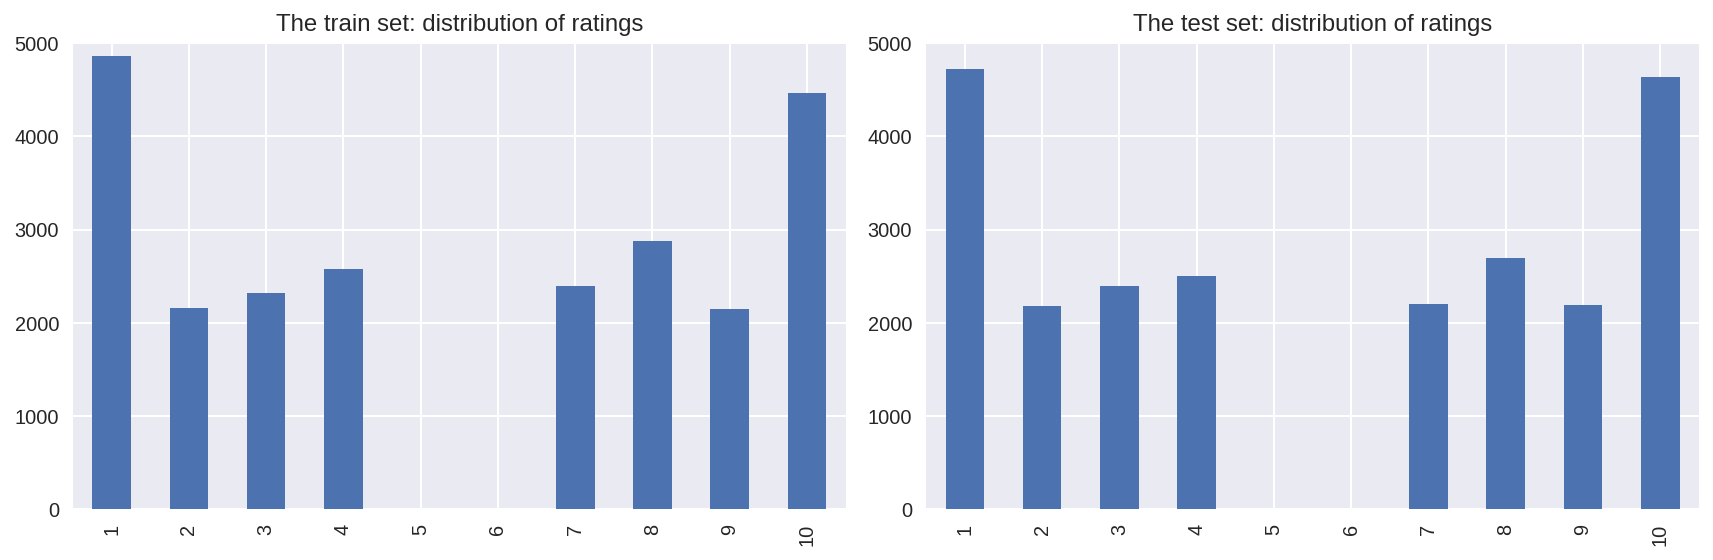

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution of ratings between training and testing data set are largely similar where rating 1 and 10 are the highest number of scores. We do not see 5 and 6 for both data set either missing data or very few reviews that are score 5 and 6.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


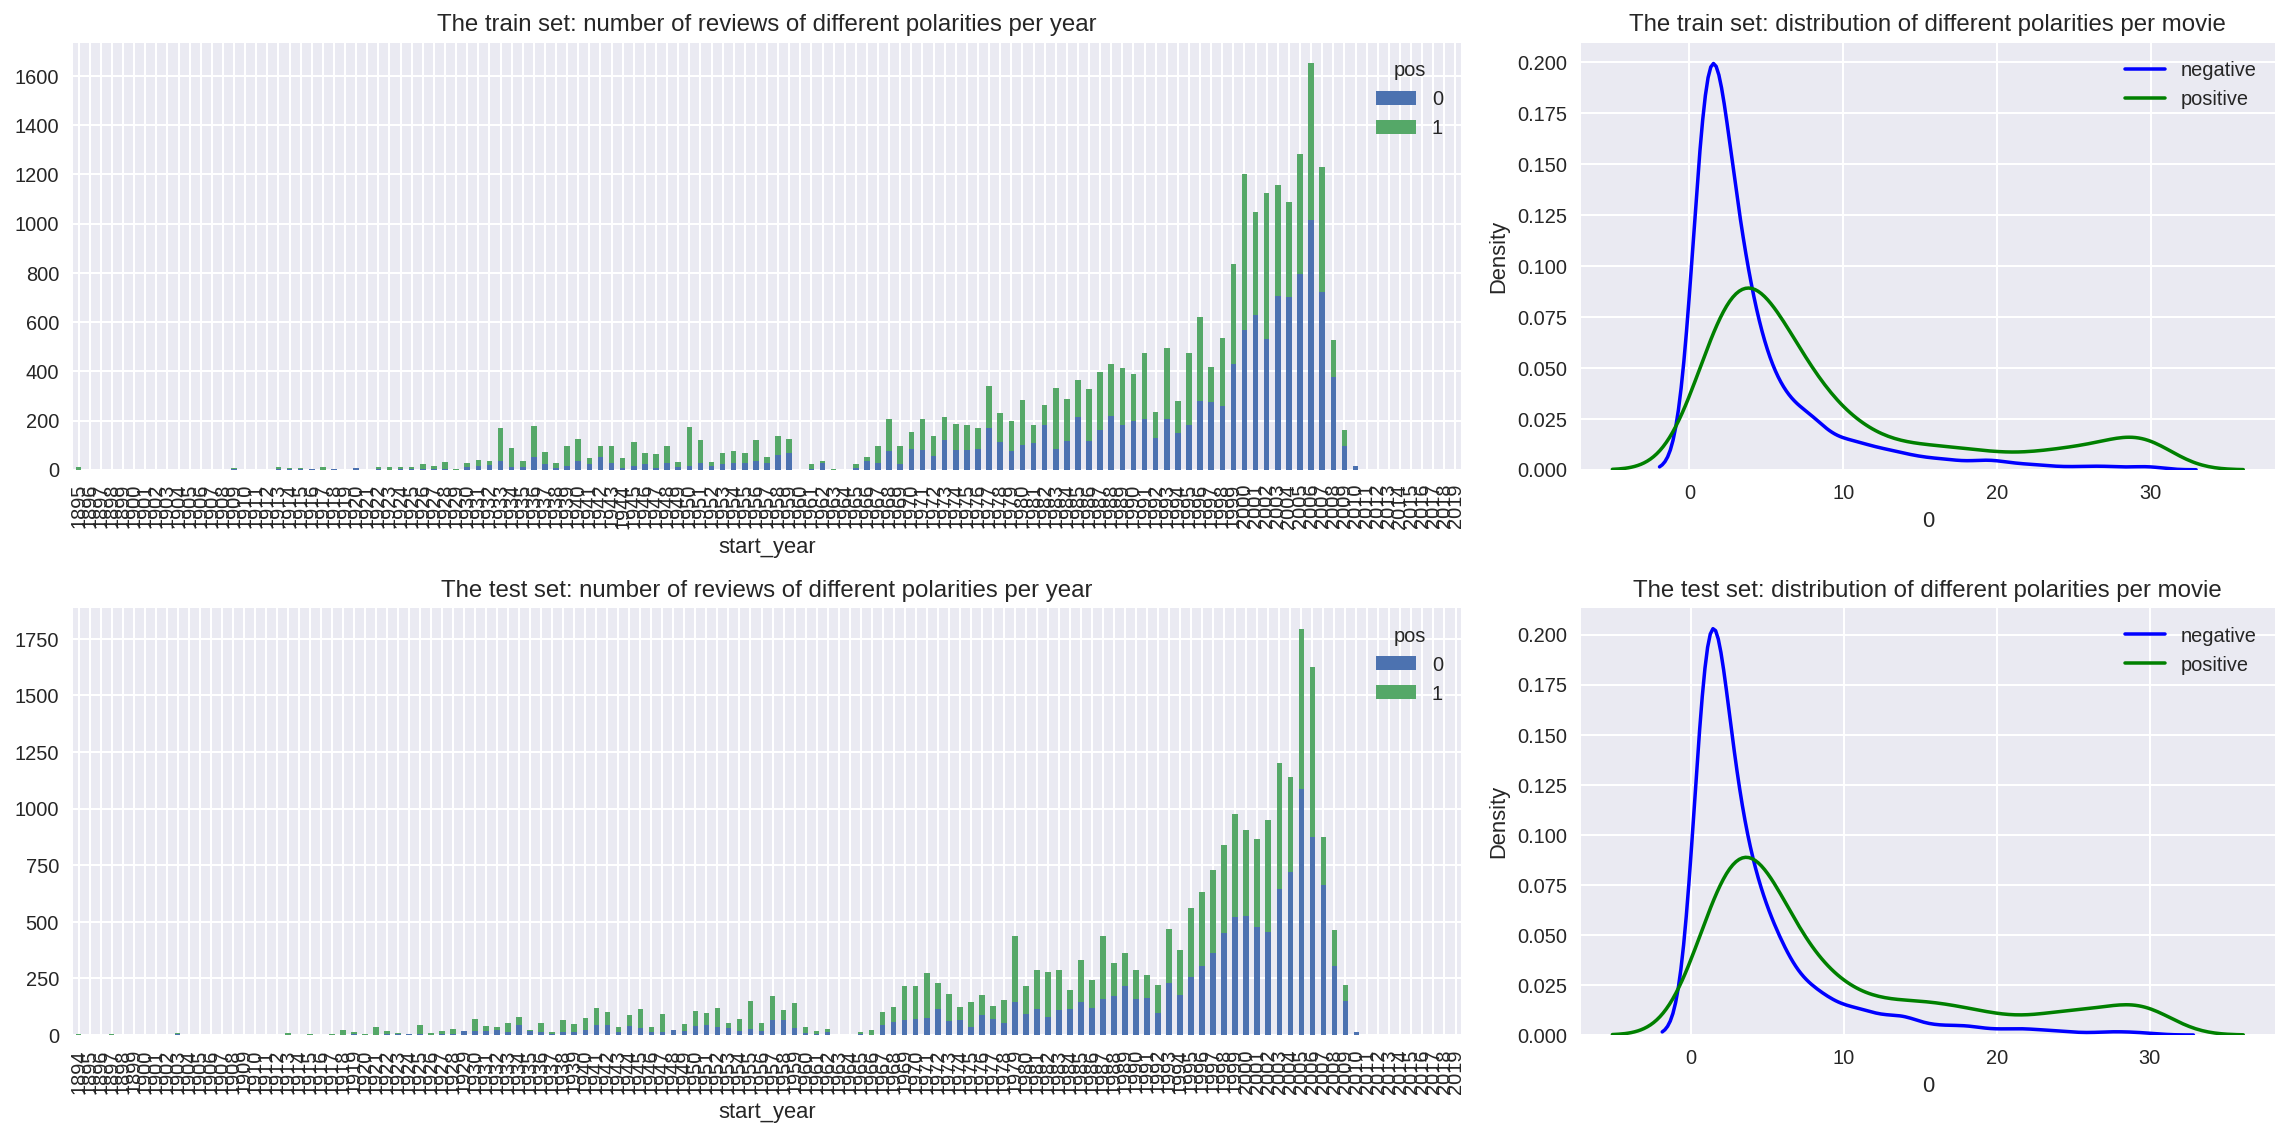

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The number of negative reviews are concentrated for movies with less than 5 reviews. For moviews with over 5 reveiws, there are more positive reviews than negative reviews.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
# Make a copy of the review column for further processing

df_reviews['review_norm'] = df_reviews['review']


In [16]:
# Create a for loop to turn words into lowercase, remove punctuations, split the words, join them with single space
# We have to split the words because there are words with extra spaces so we join then with ' ' after splitting

for row in range(0, len(df_reviews)):
    df_reviews['review_norm'][row] = re.sub('[^a-zA-Z]',' ',df_reviews['review'][row]).lower() 
    df_reviews['review_norm'][row] = df_reviews['review_norm'][row].split()
    df_reviews['review_norm'][row] = ' '.join(df_reviews['review_norm'][row])

/tmp/ipykernel_45/1796945718.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['review_norm'][row] = re.sub('[^a-zA-Z]',' ',df_reviews['review'][row]).lower()
/tmp/ipykernel_45/1796945718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['review_norm'][row] = df_reviews['review_norm'][row].split()
/tmp/ipykernel_45/1796945718.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['review_norm'][row] = 

In [17]:
df_reviews['review_norm'].head(5)

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 19)
(23533, 19)


## Working with models

### Model 0 - Constant

In [19]:
from sklearn.dummy import DummyClassifier

In [20]:
dummy_classifier = DummyClassifier()

In [21]:
dummy_classifier.fit(df_reviews_train, train_target)
prediction_test = dummy_classifier.predict(df_reviews_test)

In [22]:
dummy_score = accuracy_score(test_target, prediction_test)
print('Accuracy score for dummy model is', dummy_score)

Accuracy score for dummy model is 0.5015510134704457


### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [23]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...


True

In [24]:
# First turning each sentence in individual row to token on training data

corpus_train_1 = [ ]

for row in df_reviews_train['review_norm']:
    sentences = nltk.sent_tokenize(row)
    corpus_train_1.extend(sentences)

In [25]:
# Lemmatization for tokens for training data

lemmatizer = WordNetLemmatizer()

for sentence in range(len(corpus_train_1)):
    words = nltk.word_tokenize(corpus_train_1[sentence])
    words = [lemmatizer.lemmatize(each_word) for each_word in words if each_word not in set(stopwords.words('english'))]
    corpus_train_1[sentence] = ' '.join(words)

In [26]:
# Turning each sentence from each row to token in testing set and perform lemmatization

corpus_test_1 = [ ]

for row in df_reviews_test['review_norm']:

    sentences = nltk.sent_tokenize(row)
    corpus_test_1.extend(sentences)

lemmatizer = WordNetLemmatizer()
    
for sentence in range(len(corpus_test_1)):
    words = nltk.word_tokenize(corpus_test_1[sentence])
    words = [lemmatizer.lemmatize(each_word) for each_word in words if each_word not in set(stopwords.words('english'))]
    corpus_test_1[sentence] = " ".join(words)

In [27]:
# Using TF-IDF and exclude stopwords

count_tf_idf_1 = TfidfVectorizer(stop_words = set(stopwords.words('english')))

train_features_1 = count_tf_idf_1.fit_transform(corpus_train_1)
test_features_1 = count_tf_idf_1.transform(corpus_test_1)

In [28]:
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


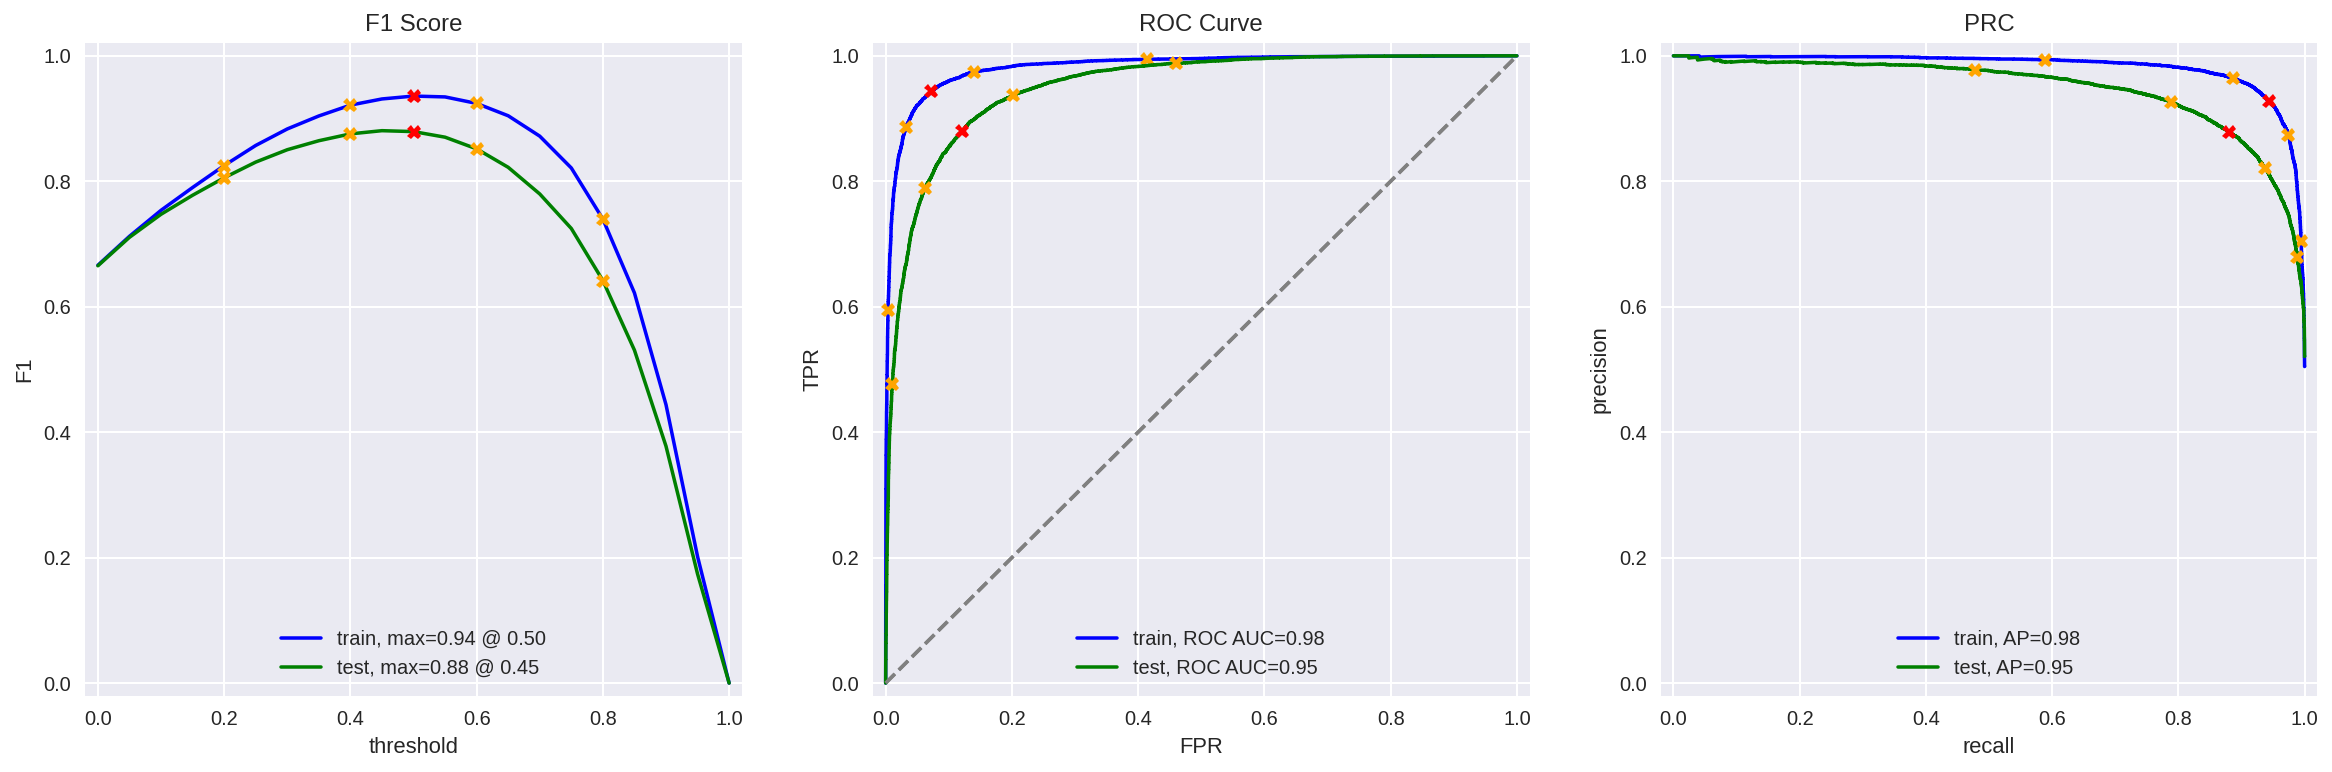

In [29]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

The F1 score for training is 0.94 but 0.88 for the test set. It is performing better than dummy classifier. However,with training F1 score performing better than testing, it may suggest that the model is overfitting the training data.

### Model 3 - spaCy, TF-IDF and LR

In [30]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

spaCy takes care of the tokenization and we can have a more streamlined code from tokenization to lemmatization

In [31]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
#     tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [32]:
train_3 = []
test_3 = []

for text in df_reviews_train['review_norm']:
    results = text_preprocessing_3(text)
    train_3.append(results)


for text in df_reviews_test['review_norm']:
    results = text_preprocessing_3(text)
    test_3.append(results)

In [33]:
count_tf_idf_3 = TfidfVectorizer(stop_words='english')

train_corpus = train_3
test_corpus = test_3

train_features_3 = count_tf_idf_3.fit_transform(train_corpus)
test_features_3 = count_tf_idf_3.transform(test_corpus)


In [34]:
model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


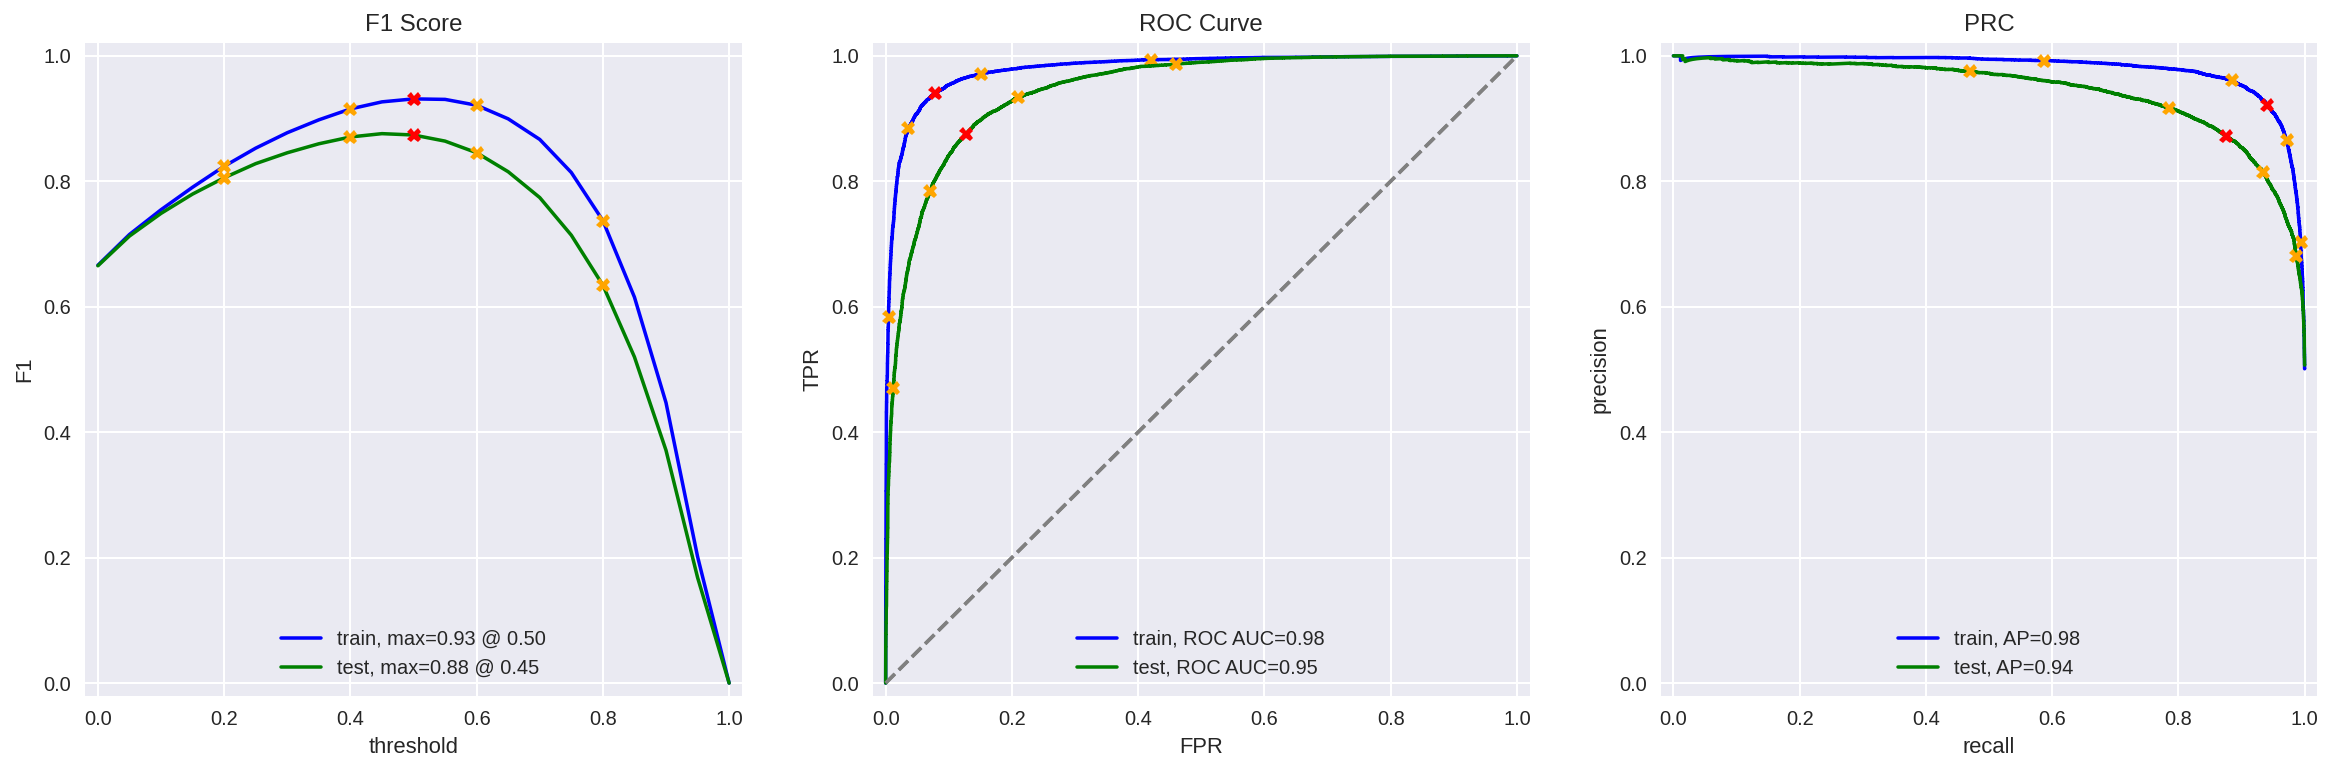

In [35]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

The F1 score is 0.93 for training and 0.87 for testing data. Again, it is performing better than dummy model but the training model maybe overfitting.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [36]:
from lightgbm import LGBMClassifier

In [37]:
train_features_4 = train_features_3.copy()
test_features_4 = test_features_3.copy()

***LightGBM: using GridSearchCV to get a range of best hyperparameters***

In [38]:

# # Create dictionary to be used in randomizedsearchcv

# lgbm_rand_dict = {'num_leaves': np.arange(17,23),
#                  'n_estimators': np.arange(25,30),
#                  'learning_rate': [0.1 * i for i in range(2,6)]}

# # Initiate model 

# lgbm = LGBMClassifier(random_state = 12345)

# # Use RandomizedSearchCV 

# grid_lgbm = GridSearchCV(lgbm, lgbm_rand_dict, scoring = 'f1', cv= 3, verbose=1)

# best_grid_lgbm = grid_lgbm.fit(train_features_4, train_target).best_params_

# print('Best hyperparameters for LGBM in randomized search is',best_grid_lgbm)



Commenting this part out to save processing time. I already had the best parameters 

In [39]:
model_4 = LGBMClassifier(random_state = 12345,
                        learning_rate = 0.6 ,
                        num_leaves = 35,
                        n_estimators = 21)

model_4.fit(train_features_4, train_target)


LGBMClassifier(learning_rate=0.6, n_estimators=21, num_leaves=35,
               random_state=12345)

          train  test
Accuracy   0.91  0.84
F1         0.91  0.85
APS        0.97  0.92
ROC AUC    0.97  0.92


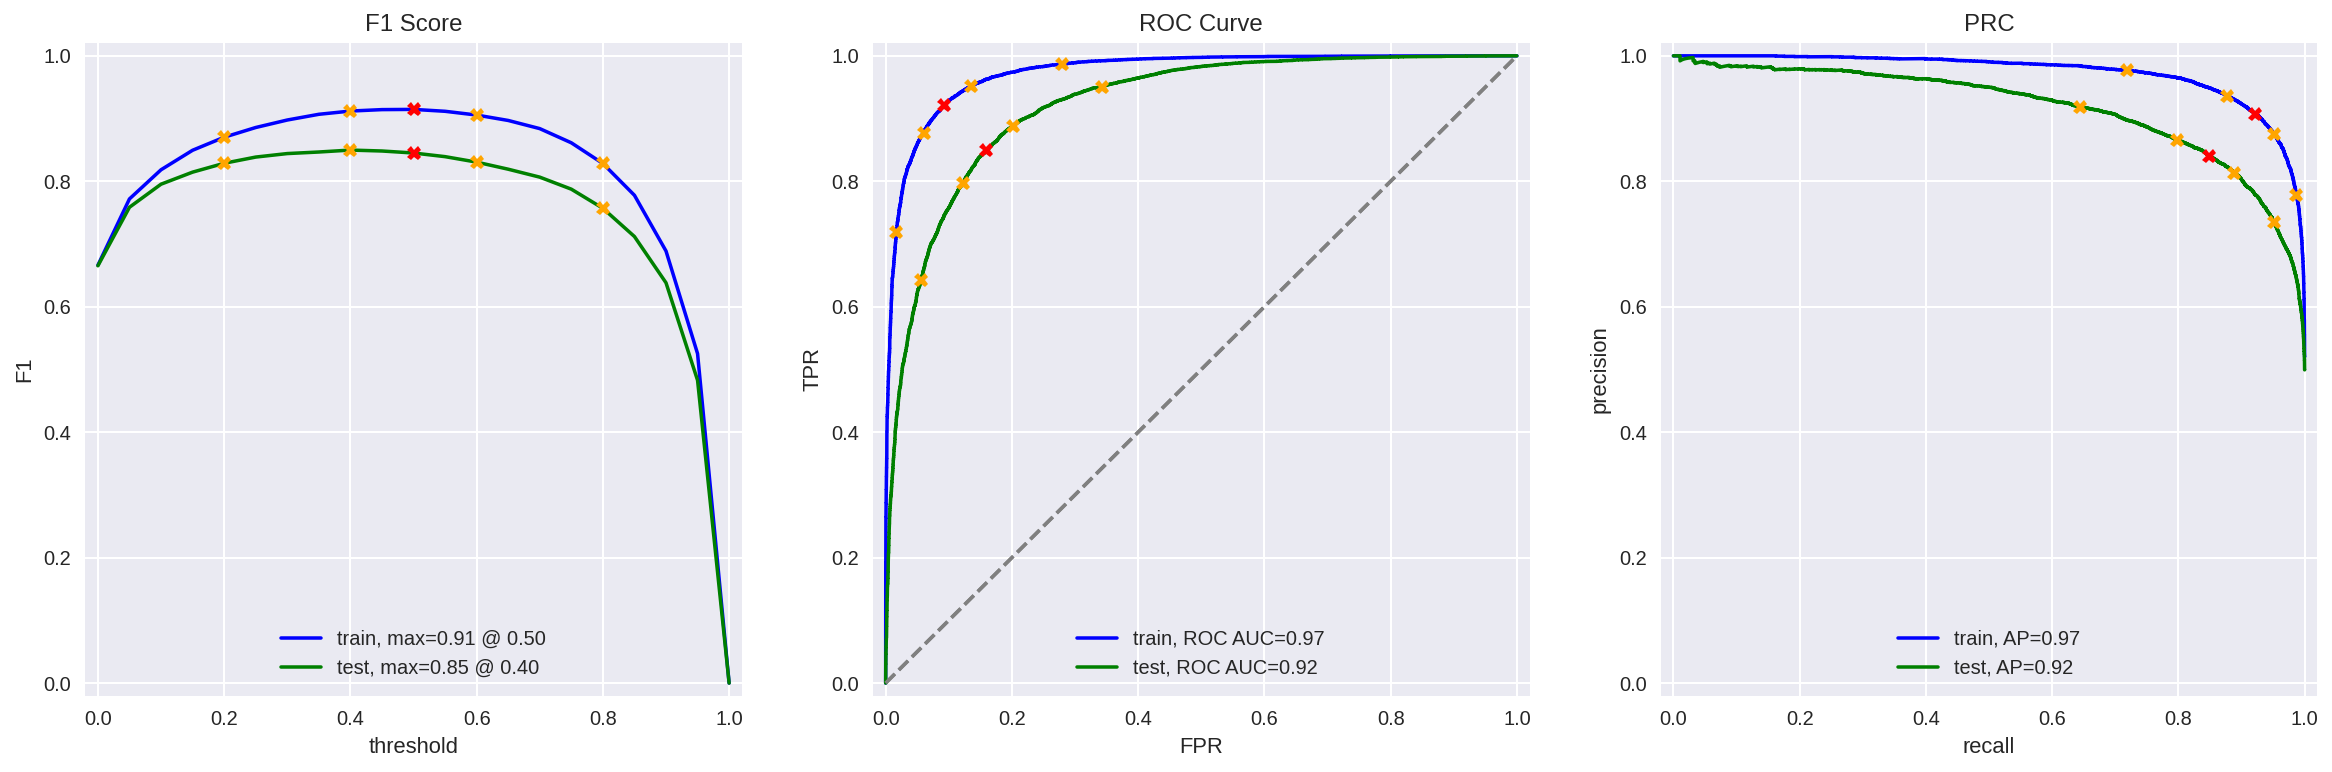

In [40]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

The F1 score is 0.91 for training set and 0.85 for testing set. LightGBM has the lowest F1 score

###  Model 9 - BERT

In [41]:
import torch
import transformers

In [42]:

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 1.10.0+cu102
Is CUDA enabled? False


The original code in the example was using CUDA but it does not seem like the virutal environment has CUDA installed on Triple Ten. Therefore, I ran BERT on CPU instead.

In [43]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=10, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    for input_text in df_reviews.iloc[:100]['review']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padding = ids + [0] * (max_length - len(ids))
        attention_mask = [1] * len(ids) + [0] * (max_length - len(ids))
        ids_list.append(padding)
        attention_mask_list.append(attention_mask)

    device = torch.device('cpu')
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size * i:batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i:batch_size * (i + 1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)

Tested multiple times and kernel dies if the batch_size is too large. Therefore, adjusted it down to 10 otherwise the notebook would not run.

In [45]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'][:100], force_device='cuda')
train_target_9 =df_reviews_train.iloc[:100]['pos']

Using the cpu device.


  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'][:100],force_device='cuda')
test_target_9 = df_reviews_test.iloc[:100]['pos']

Using the cpu device.


  0%|          | 0/10 [00:00<?, ?it/s]

In [47]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(100, 768)
(23796,)


In [48]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

In [49]:
model_9 = LogisticRegression()
model_9.fit(train_features_9, train_target_9)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

          train  test
Accuracy    1.0  0.73
F1          1.0  0.77
APS         1.0  0.66
ROC AUC     1.0  0.75


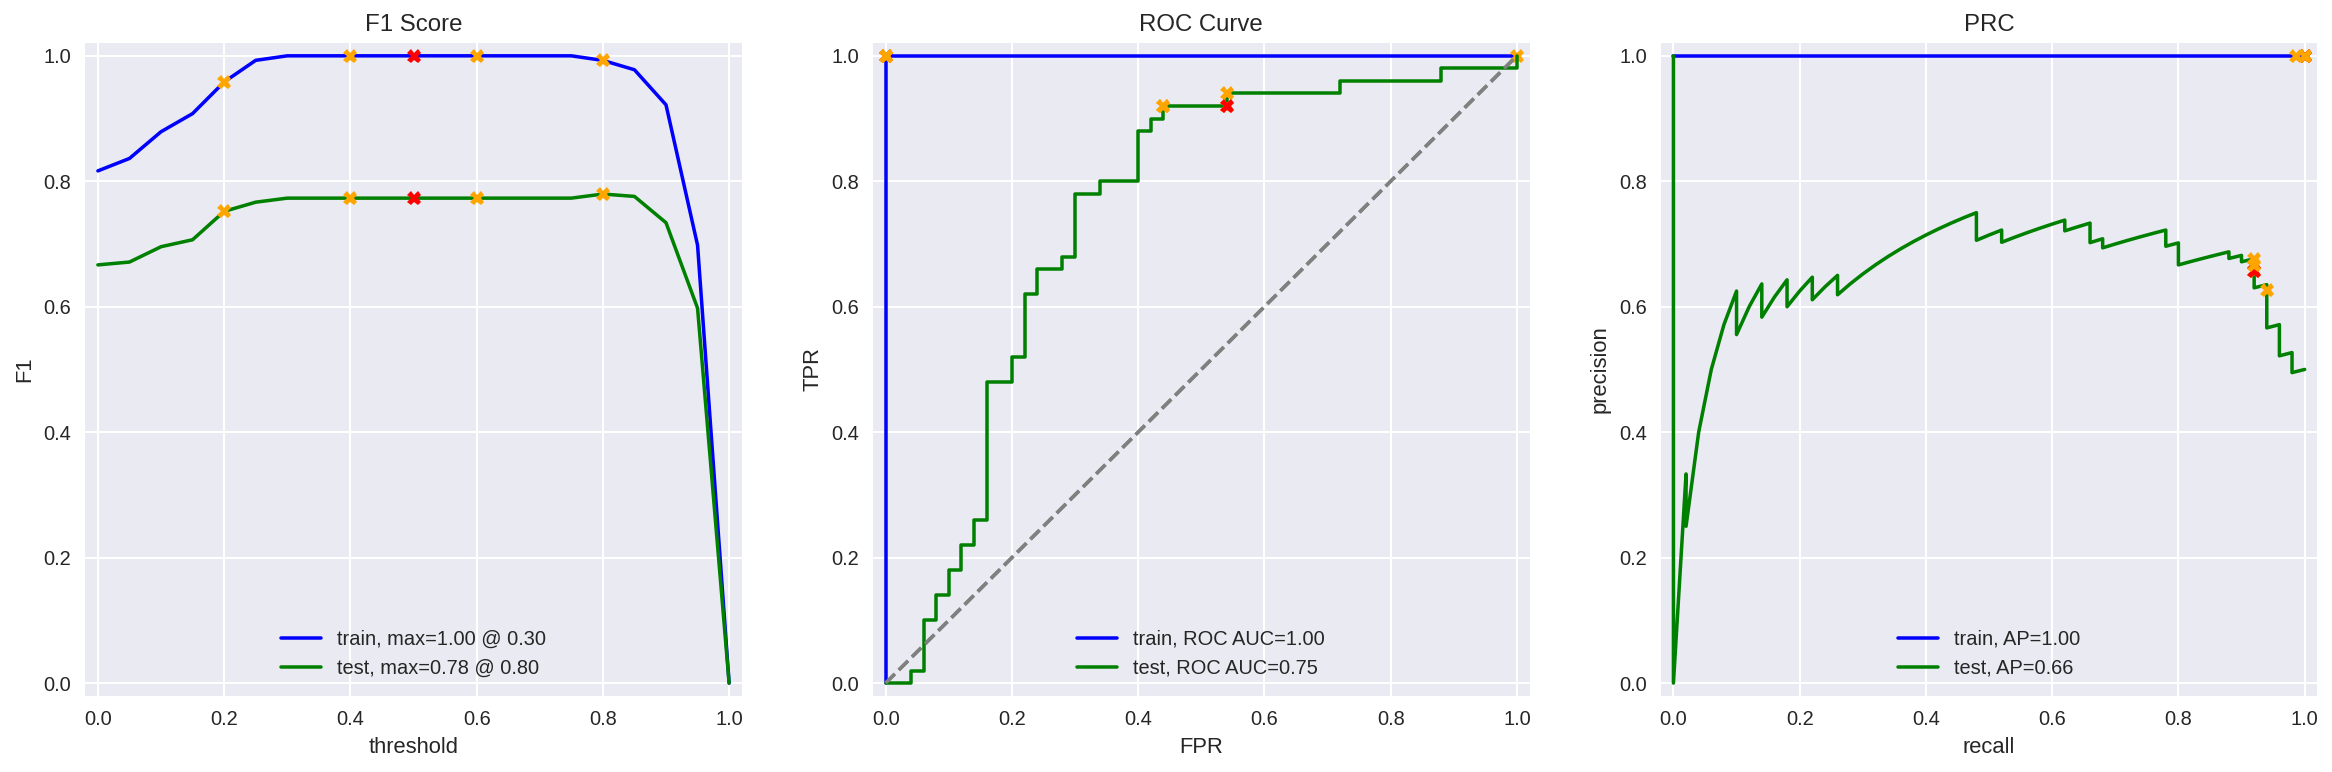

In [50]:
evaluate_model(model_9, train_features_9, train_target_9, test_features_9, test_target_9)


Bert performs perfectly on training set but not so well in training set with F1 score of 0.77. However, the sample size was reduced down to 100 reviews whereas other models trained on 23796 reviews. If we have the resources and for better estimation, we can increase the sample size to the actual sample size.

Quite impressive with Bert we only have 100 sample size and it can reach F1 score of 0.77 for testing which is significantly better than baseline model.

## My Reviews

In [51]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'] # <put here the same normalization logic as for the main dataset>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.","I did not simply like it, not my kind of movie."
1,"Well, I was bored and felt asleep in the middl...","Well, I was bored and felt asleep in the middl..."
2,I was really fascinated with the movie,I was really fascinated with the movie
3,Even the actors looked really old and disinter...,Even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,I didn't expect the reboot to be so good! Writ...
5,"The movie had its upsides and downsides, but I...","The movie had its upsides and downsides, but I..."
6,What a rotten attempt at a comedy. Not a singl...,What a rotten attempt at a comedy. Not a singl...
7,Launching on Netflix was a brave move & I real...,Launching on Netflix was a brave move & I real...


In [52]:
for row in range(0, len(my_reviews)):
    my_reviews['review_norm'][row] = re.sub('[^a-zA-Z]', ' ', my_reviews['review_norm'][row].lower())
    my_reviews['review_norm'][row] = my_reviews['review_norm'][row].split()
    my_reviews['review_norm'][row] = ' '.join(my_reviews['review_norm'][row])

### Model 1

In [53]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.35:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [54]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.52:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.20:  i didn t expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [55]:
texts = my_reviews['review_norm']

count_tf_idf_4 = count_tf_idf_3
my_reviews_pred_prob = model_4.predict_proba(count_tf_idf_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it not my kind of movie
0.28:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.35:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.83:  i didn t expect the reboot to be so good writers really cared about the source material
0.60:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.13:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 9

In [56]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.18:  i did not simply like it not my kind of movie
0.21:  well i was bored and felt asleep in the middle of the movie
0.14:  i was really fascinated with the movie
0.06:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.00:  i didn t expect the reboot to be so good writers really cared about the source material
0.21:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.25:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

The goal of the project is to train models to predict whether movie reviews would be positive or negative. 

We first removed the few rows with NA values in ratings and average ratings. Afterwards, we studied the number of review and distribution of ratings. We also evaluated the distribution of positive and negative review in both training and testing set to ensure we do not have imbalance of class for target.

We created a function to calculate accuracy and F1 score to be used. We then normalize the reviews by removing punctuations, extra spaces and convert them to lower case before we pass them to our models.

Baseline model has accuracy score of 0.5. 
- Model 1: NLTK + TfIDF + LR has F1 score of 0.94 in training and 0.88 for testing
- Model 3: spaCy + TfIDF + LR has F1 score of 0.93 in training and 0.87 for testing
- Model 4: spaCy + TfIDF + LGBM has F1 score of 0.91 in training and 0.85 for testing
- Model 9: Bert has F1 score of 1.0 in training and 0.77 for testing

In testing the model in `my_reviews` Bert performs the worst while spaCy with LGBM seems to have better prediction. Model 1 with NLTK also have accurate sentiment of the reviews but less confident or probability not as high. 

Final thought is that I do not think we can compre BERT directly to other models as the sample size was 100 whereas the models were trainied on 23796 reviews.
